In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2


In [ ]:
# ฟังก์ชันดึงข้อมูล
def download_wti_data(file_path='Data_T.csv'):
    data = pd.read_csv(file_path)
    
    if 'Volume' in data.columns:
        data['Volume'] = data['Volume'].str.replace(',', '').astype(float)
    
    if 'Date' in data.columns:
        data['Date'] = pd.to_datetime(data['Date'])
        data.set_index('Date', inplace=True)
    
    required_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in required_columns:
        if col not in data.columns:
            raise ValueError(f"Missing required column: {col}")
    
    return data

In [3]:
def handle_missing_values(data):
    price_cols = ['Open', 'High', 'Low', 'Close']
    data[price_cols] = data[price_cols].ffill().bfill()
    
    if 'Volume' in data.columns:
        data['Volume'] = data['Volume'].fillna(data['Volume'].median())
    
    return data

In [4]:
def handle_outliers(data, threshold=3.0):
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        if col not in ['Close', 'Open', 'High', 'Low']:
            z_scores = np.abs((data[col] - data[col].mean()) / data[col].std())
            data[col] = np.where(z_scores > threshold, data[col].median(), data[col])
    
    return data

In [ ]:
#  จัดการข้อมูล
def preprocess_data(data):
    data = handle_missing_values(data)
    data = handle_outliers(data)
    return data

In [6]:
def calculate_rsi(series, period):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

In [7]:
def calculate_atr(data, period):
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return tr.rolling(window=period).mean()

In [8]:
def calculate_obv(data):
    obv = np.zeros(len(data))
    obv[0] = data['Volume'].iloc[0]
    
    for i in range(1, len(data)):
        if data['Close'].iloc[i] > data['Close'].iloc[i-1]:
            obv[i] = obv[i-1] + data['Volume'].iloc[i]
        elif data['Close'].iloc[i] < data['Close'].iloc[i-1]:
            obv[i] = obv[i-1] - data['Volume'].iloc[i]
        else:
            obv[i] = obv[i-1]
    return obv


In [ ]:
# 3. คำนวณ Technical Indicators
def calculate_technical_indicators(data):
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()
    data['RSI_14'] = calculate_rsi(data['Close'], 14)
    data['ROC_10'] = data['Close'].pct_change(periods=10)
    data['Momentum_5'] = data['Close'] - data['Close'].shift(5)
    data['ATR_14'] = calculate_atr(data, 14)
    data['Volatility_10'] = data['Close'].pct_change().rolling(10).std()
    data['OBV'] = calculate_obv(data)
    data['Volume_MA_10'] = data['Volume'].rolling(10).mean()
    
    return data.dropna()

In [ ]:
# แปลงข้อมูล
def transform_data(data):
    data['Open_Relative'] = (data['Open'] - data['Close']) / data['Close']
    data['High_Relative'] = (data['High'] - data['Close']) / data['Close']
    data['Low_Relative'] = (data['Low'] - data['Close']) / data['Close']
    data['SMA_20_Relative'] = (data['SMA_20'] - data['Close']) / data['Close']
    data['Close_Change'] = data['Close'].pct_change()
    data['Volume_Change'] = data['Volume'].pct_change()
    data['OBV_Change'] = data['OBV'].pct_change()
    data['Log_Return'] = np.log(data['Close'] / data['Close'].shift(1))
    
    skewed_features = ['Volume', 'OBV', 'Volume_MA_10']
    qt = QuantileTransformer(output_distribution='normal')
    for feature in skewed_features:
        if feature in data.columns:
            data[f'{feature}_QT'] = qt.fit_transform(data[[feature]])
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    features_to_scale = ['RSI_14', 'ROC_10', 'ATR_14', 'Close_Change', 
                         'Volume_QT', 'OBV_QT', 'Open_Relative', 'High_Relative',
                         'Low_Relative', 'SMA_20_Relative', 'Volatility_10',
                         'Momentum_5', 'Volume_Change', 'OBV_Change']
    
    features_to_scale = [f for f in features_to_scale if f in data.columns]
    data[features_to_scale] = scaler.fit_transform(data[features_to_scale])
    
    return data.dropna()

In [ ]:
# สร้าง labels
def create_labels(data, window=21, poly_order=2):
    smoothed_close = savgol_filter(data['Close'], window_length=window, polyorder=poly_order)
    daily_return = np.zeros(len(smoothed_close))
    daily_return[1:] = np.log(smoothed_close[1:] / smoothed_close[:-1])
    return daily_return

In [ ]:
# เตรียมข้อมูล
def prepare_lstm_data(data, labels, n_steps=30):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data.iloc[i:i+n_steps].values)
        y.append(labels[i+n_steps])
    return np.array(X), np.array(y)

In [ ]:
# แบ่งข้อมูลตามปี
def split_data_by_year(X, y, dates, test_years):
    train_sets, val_sets, test_sets = [], [], []
    
    for year in test_years:
        train_start = pd.to_datetime(f'{year-11}-01-01')
        train_end = pd.to_datetime(f'{year-2}-12-31')
        train_mask = (dates >= train_start) & (dates <= train_end)
        
        val_start = pd.to_datetime(f'{year-1}-01-01')
        val_end = pd.to_datetime(f'{year-1}-12-31')
        val_mask = (dates >= val_start) & (dates <= val_end)
        
        test_start = pd.to_datetime(f'{year}-01-01')
        test_end = pd.to_datetime(f'{year}-12-31')
        test_mask = (dates >= test_start) & (dates <= test_end)
        
        train_sets.append((X[train_mask], y[train_mask]))
        val_sets.append((X[val_mask], y[val_mask]))
        test_sets.append((X[test_mask], y[test_mask]))
    
    return train_sets, val_sets, test_sets

In [ ]:
# สร้างโมเดล LSTM
def build_lstm_model(input_shape, lstm_units=128):
    model = Sequential([
        LSTM(lstm_units, return_sequences=True, input_shape=input_shape,
             recurrent_dropout=0.2, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        
        LSTM(64, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        
        Dense(1, kernel_regularizer=l2(0.01))
    ])
    
    optimizer = Adam(learning_rate=1e-4, clipvalue=0.5)
    model.compile(optimizer=optimizer, loss='mse')
    return model

In [ ]:
# กราฟแสดงผลลัพธ์ MSE 
def plot_mse_results(test_years, mse_values):
    """พล็อตผลลัพธ์ MSE ทุกปีแบบแท่ง"""
    plt.figure(figsize=(12, 6))
    
    # สร้างกราฟแท่ง
    bars = plt.bar(test_years, mse_values, color='skyblue', edgecolor='black')
    
    # เพิ่มค่าตัวเลขบนแต่ละแท่ง
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}',
                 ha='center', va='bottom', fontsize=10)
    
    plt.title('Test MSE Across Years', fontsize=14, pad=20)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Test MSE (10^-2 %^2)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.ylim(0, max(mse_values) * 1.1)
    
    plt.show()


In [ ]:
def main():
    wti_data = download_wti_data()
    wti_data = preprocess_data(wti_data)
    wti_data = calculate_technical_indicators(wti_data)
    transformed_data = transform_data(wti_data)
    labels = create_labels(wti_data)
    
    # เลือก features
    selected_features = ['RSI_14', 'ROC_10', 'ATR_14', 'Close_Change', 
                        'Volume_QT', 'OBV_QT', 'Open_Relative', 'High_Relative',
                        'Low_Relative', 'SMA_20_Relative', 'Volatility_10',
                        'Momentum_5', 'Log_Return']
    selected_features = [f for f in selected_features if f in transformed_data.columns]
    feature_data = transformed_data[selected_features]
    
    # เตรียมข้อมูล LSTM
    X, y = prepare_lstm_data(feature_data, labels)
    dates = transformed_data.index[30:]
    
    # แบ่งข้อมูลตามปี
    test_years = [2015, 2016, 2017, 2018, 2019, 2020]
    train_sets, val_sets, test_sets = split_data_by_year(X, y, dates, test_years)
    
    mse_results = []
    
    for i, year in enumerate(test_years):
        print(f"\n=== Training for year {year} ===")
        
        X_train, y_train = train_sets[i]
        X_val, y_val = val_sets[i]
        X_test, y_test = test_sets[i]
        
        # สร้างและฝึกโมเดล
        model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
        
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=50,
            restore_best_weights=True,
            min_delta=0.001
        )
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=500,
            batch_size=64,
            callbacks=[early_stopping],
            verbose=1
        )
        
        # ประเมินโมเดล
        test_pred = model.predict(X_test)
        test_mse = mean_squared_error(y_test, test_pred) * 10000  # มีหน่วยเป็น 10^-2 %^2
        
        print(f"Test MSE: {test_mse:.6f} (10^-2 %^2)")
        mse_results.append(test_mse)
    
    # แสดงผลลัพธ์ MSE
    print("\n=== สรุปผลลัพธ์ MSE ทุกปี ===")
    for year, mse in zip(test_years, mse_results):
        print(f"Year {year}: MSE = {mse:.6f} (10^-2 %^2)")
    
    # พล็อตกราฟ MSE
    plot_mse_results(test_years, mse_results)

C:\Users\bqckz\AppData\Local\Temp\ipykernel_2304\2470096138.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'])
c:\Users\bqckz\anaconda3\envs\bqckz\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



=== Training for year 2015 ===
Epoch 1/500
36/36 [==============================] - 8s 85ms/step - loss: 3.5348 - val_loss: 2.4063
Epoch 2/500
36/36 [==============================] - 2s 69ms/step - loss: 3.2287 - val_loss: 2.3870
Epoch 3/500
36/36 [==============================] - 2s 67ms/step - loss: 2.9873 - val_loss: 2.3621
Epoch 4/500
36/36 [==============================] - 2s 62ms/step - loss: 2.8421 - val_loss: 2.3376
Epoch 5/500
36/36 [==============================] - 2s 61ms/step - loss: 2.7296 - val_loss: 2.3124
Epoch 6/500
36/36 [==============================] - 2s 63ms/step - loss: 2.6489 - val_loss: 2.2876
Epoch 7/500
36/36 [==============================] - 2s 62ms/step - loss: 2.5706 - val_loss: 2.2608
Epoch 8/500
36/36 [==============================] - 2s 61ms/step - loss: 2.5029 - val_loss: 2.2348
Epoch 9/500
36/36 [==============================] - 2s 64ms/step - loss: 2.4230 - val_loss: 2.2047
Epoch 10/500
36/36 [==============================] - 2s 61ms/step -

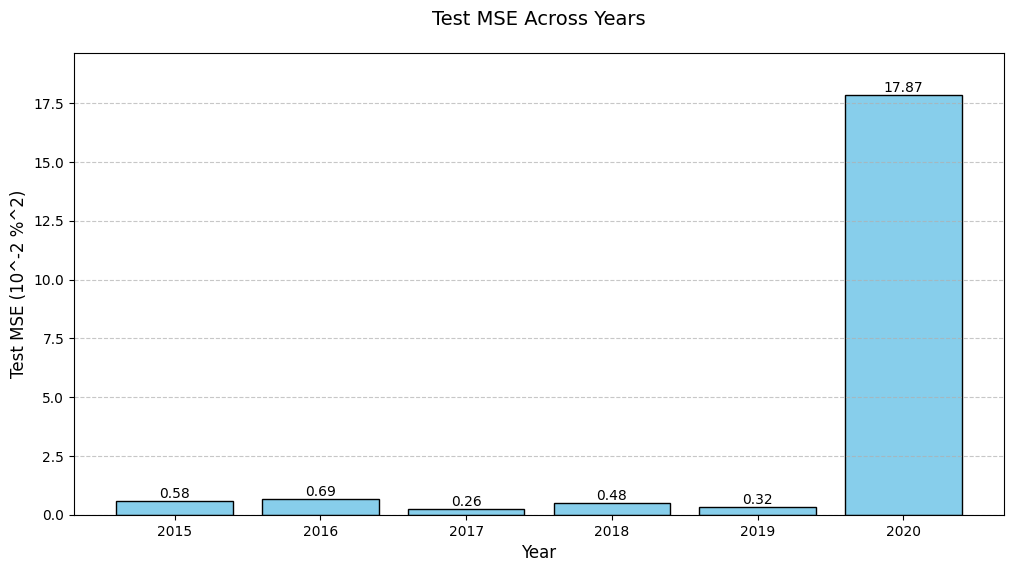

In [ ]:
if __name__ == "__main__":
    main()